In [1]:
!module list

Currently Loaded Modulefiles:
 1) courses/cs435/pa3   3) ide/visual-studio-code  
 2) python/bundle-3.9   4) cuda/11.2               
>

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
image_dir = "/s/bach/a/class/cs435/cs435a/CS435_Plant_Data/"
train_dir = '/s/bach/a/class/cs435/cs435a/CS435_Plant_Data/train'
val_dir = '/s/bach/a/class/cs435/cs435a/CS435_Plant_Data/valid'
test_dir = "/s/bach/a/class/cs435/cs435a/CS435_Plant_Data/test"

In [38]:
pipeline_params = {
    'labels': 'inferred',
    'label_mode': 'int',
    'batch_size': 32,
    'image_size': (224, 224),
    'shuffle': True
}

train_pipeline = tf.keras.utils.image_dataset_from_directory(
    f'{train_dir}',
    **pipeline_params
)

valid_pipeline = tf.keras.utils.image_dataset_from_directory(
    f'{val_dir}',
    **pipeline_params
)

test_pipeline = tf.keras.utils.image_dataset_from_directory(
    f'{test_dir}',
    **pipeline_params
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found 33 files belonging to 8 classes.


In [5]:
base_model=tf.keras.applications.VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
base_model.trainable=False

In [6]:
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [7]:
vgg_model=keras.models.Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(4096,activation='relu'))
vgg_model.add(Dense(4096,activation='relu'))
vgg_model.add(Dense(38,activation='softmax'))
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 38)                155686    
                                                                 
Total params: 134,416,230
Trainable params: 119,701,542
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
vgg_model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [9]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.1,
                              patience=3,
                              mode='max',
                              restore_best_weights=True
                              )

In [10]:
model_history = vgg_model.fit(
    train_pipeline,
#     steps_per_epoch=train_num//batch_size,
    validation_data=valid_pipeline,
    epochs=3,
#     validation_steps=valid_num//batch_size,
    callbacks=[earlystopping]
)

Epoch 1/3


2023-11-10 15:08:16.319512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


2197/2197 [==============================] - ETA: 0s - loss: 1.6213 - accuracy: 0.7961

2023-11-10 15:11:55.028143: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-11-10 15:12:00.270664: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


2197/2197 [==============================] - 234s 101ms/step - loss: 1.6213 - accuracy: 0.7961 - val_loss: 0.3806 - val_accuracy: 0.8983
Epoch 2/3
2197/2197 [==============================] - 210s 95ms/step - loss: 0.2642 - accuracy: 0.9275 - val_loss: 0.3452 - val_accuracy: 0.9136
Epoch 3/3
2197/2197 [==============================] - 211s 96ms/step - loss: 0.2085 - accuracy: 0.9494 - val_loss: 0.3263 - val_accuracy: 0.9150


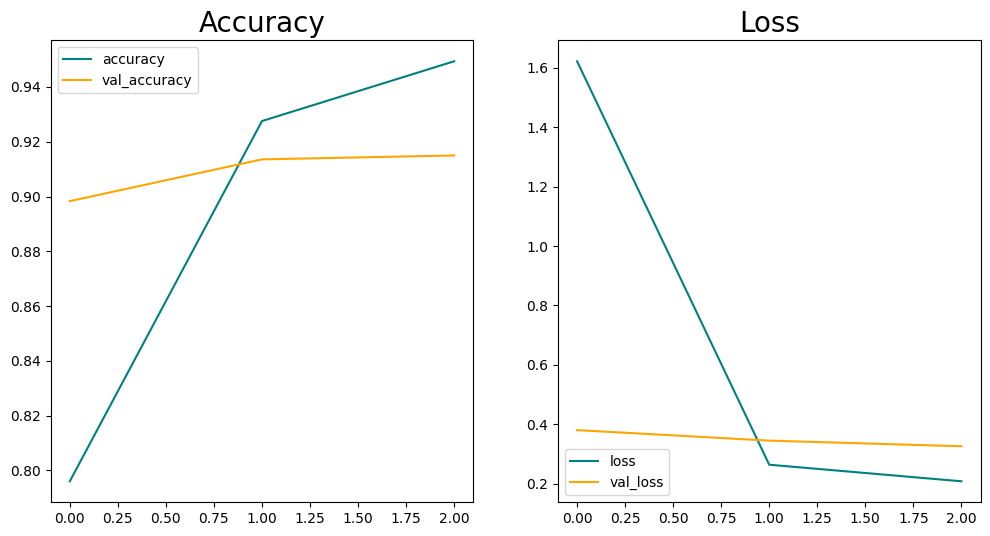

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
 
plt.subplot(121)
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')
 
plt.subplot(122)
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
# plt.yscale('log')
plt.title('Loss', fontsize=20)
plt.legend(loc='lower left')
plt.show()

In [63]:
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
 
def evaluate_model(model, test_set):
    y_true = []
    y_pred = []
 
    batch_size = 32
    batch_predictions = []
 
    for data, labels in test_set:
        y_true.extend(labels.numpy())
        batch_data = []
 
        for img in data:
            img_np = img.numpy()
            resized_image = cv2.resize(img_np, (224, 224))
            resized_image = resized_image.reshape(1, 224, 224, 3)
            batch_data.append(resized_image)
 
        batch_data = np.vstack(batch_data)
        batch_pred = model.predict(batch_data)
 
        batch_predictions.append(batch_pred)
    y_pred = np.vstack(batch_predictions)
    y_pred_classes = np.argmax(y_pred, axis=1) 
    
    
    precision = precision_score(y_true, y_pred_classes, average="weighted")
    recall = recall_score(y_true, y_pred_classes, average="weighted")
    f1 = f1_score(y_true, y_pred_classes, average="weighted")
    accuracy = accuracy_score(y_true, y_pred_classes)
    return precision, recall, f1, accuracy, np.array(y_true), np.array(y_pred_classes)

In [64]:
precision, recall, f1, acc, y_true, y_pred_classes = evaluate_model(vgg_model, test_pipeline)

1/1 [==============================] - 0s 14ms/step


/usr/local/python-env/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python-env/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
import pandas as pd
pd.DataFrame([{
    'Rank Precision': f'{precision:.4f}',
    'Rank Recall': f'{recall:.4f}',
    'Rank F1': f'{f1:.4f}',
    'Rank Accuracy': f'{acc:.4f}'
}])

,Rank Precision,Rank Recall,Rank F1,Rank Accuracy
0,0.0909,0.0606,0.0727,0.0606


In [66]:
y_pred_classes

array([37,  2,  8, 22, 29, 32, 20, 35, 35, 29, 30,  2, 35, 34,  8, 20, 35,
        0, 35, 29, 20, 37, 37,  2, 20, 27,  8, 32, 22, 20,  0, 32, 35])

ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of ticklabels (38).

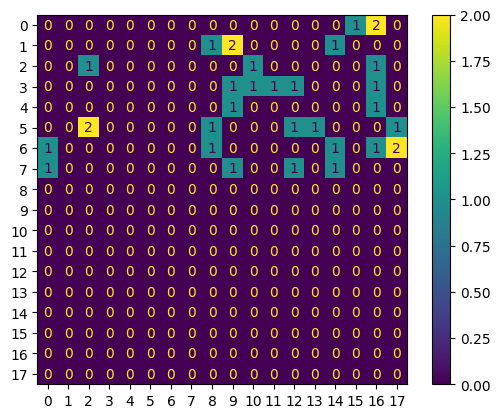

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Assuming you have a test dataset called suit_test and labels called suit_test_labelspredictions = suit_model.predict(suit_test) 

class_labels = train_pipeline.class_names
# print("Class labels:", class_labels)
cm = confusion_matrix(y_true, y_pred_classes) 
# print("Confusion Matrix:")
# print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_labels)

# tick_marks = np.arange(len(class_labels))
# plt.xticks(tick_marks, class_labels, rotation=45)
# plt.yticks(tick_marks, class_labels)
disp.plot()
plt.show()

In [77]:
# # Assuming you have a test dataset and labels
# predictions = vgg_model.predict(test_pipeline)

# # Convert softmax outputs to class indices
# y_pred_classes = np.argmax(predictions, axis=1)

# # Assuming y_true is your true labels array and is already in the correct shape
# class_labels = train_pipeline.class_names

# # Create the confusion matrix
# cm = confusion_matrix(y_true, y_pred_classes)

# # Create the display object for the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# # Plot the confusion matrix
# disp.plot()

# # Set the tick marks for the confusion matrix
# tick_marks = np.arange(len(class_labels))
# plt.xticks(tick_marks, class_labels, rotation=45)  # Rotate x-axis labels for clarity
# plt.yticks(tick_marks, class_labels)

# # Display the plot
# plt.show()